In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

%matplotlib inline

# Set pandas to display floats in normal decimal format
pd.set_option('display.float_format', '{:.3f}'.format)

# Set visual style
sns.set_style("dark")
plt.rcParams["axes.facecolor"] = "#FDFFE2"
plt.rcParams["figure.facecolor"] = "#FDFFE2"
plt.rcParams["axes.edgecolor"] = "#FDFFE2"
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.labelpad"] = 14

# Load dataset
fires_df = pd.read_csv('fires.csv')

# Drop the index column
fires_df = fires_df.drop(columns=["Unnamed: 0"])

def quick_profile(df: pd.DataFrame) -> None:
    """
    Generate a quick profile of a pandas DataFrame.
    
    Args:
        df (pd.DataFrame): Input dataset.
    """
    print("DATASET PROFILE")
    print("=" * 60)

    # --- Basic info ---
    print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    # --- Column types ---
    print("\nColumn Types:")
    print(df.dtypes.value_counts().to_string())

    # --- Numeric summary ---
    numeric_cols = df.select_dtypes(include="number").columns
    if numeric_cols.any():
        print("\nNumeric Columns Summary:")
        display(df[numeric_cols].describe().T.round(2))  # nicer table in Jupyter

    # --- Categorical summary ---
    categorical_cols = df.select_dtypes(include=["object", "category"]).columns
    if categorical_cols.any():
        print("\nCategorical Columns:")
        for col in categorical_cols:
            unique_count = df[col].nunique(dropna=True)
            print(f"  {col}: {unique_count} unique values")

            value_counts = df[col].value_counts(dropna=False)
            if unique_count <= 20:
                print(f"    Top values: {dict(value_counts.head(5))}")
            else:
                print(f"    Most common: {value_counts.index[0]} ({value_counts.iloc[0]})")

    # --- Missing values ---
    missing = df.isnull().sum()
    if missing.any():
        print("\nMissing Values:")
        missing_df = (
            missing[missing > 0]
            .to_frame("count")
            .assign(percent=lambda x: (x["count"] / len(df) * 100).round(1))
        )
        display(missing_df)

display(fires_df.head())
quick_profile(fires_df)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.200,26.200,94.300,5.100,NaN,51.000,6.700,0.000,0.000
1,7,4,oct,tue,90.600,NaN,669.100,6.700,18.000,33.000,0.900,0.000,0.000
2,7,4,oct,sat,90.600,43.700,NaN,6.700,14.600,33.000,1.300,0.000,0.000
3,8,6,mar,fri,91.700,33.300,77.500,9.000,8.300,97.000,4.000,0.200,0.000
4,8,6,mar,sun,89.300,51.300,102.200,9.600,11.400,99.000,NaN,0.000,0.000


DATASET PROFILE
Shape: 517 rows × 13 columns
Memory usage: 0.09 MB

Column Types:
float64    9
int64      2
object     2

Numeric Columns Summary:


,count,mean,std,min,25%,50%,75%,max
X,517.000,4.670,2.310,1.000,3.000,4.000,7.000,9.000
Y,517.000,4.300,1.230,2.000,4.000,4.000,5.000,9.000
FFMC,469.000,90.580,5.700,18.700,90.200,91.600,92.800,96.200
DMC,496.000,111.200,64.010,1.100,70.800,108.300,141.580,291.300
DC,474.000,550.670,246.060,7.900,441.200,664.500,713.900,860.600
ISI,515.000,9.020,4.560,0.000,6.450,8.400,10.750,56.100
temp,496.000,18.880,5.750,2.200,15.480,19.300,22.720,33.300
RH,487.000,44.380,16.180,15.000,33.000,42.000,53.500,100.000
wind,482.000,4.020,1.790,0.400,2.700,4.000,4.900,9.400
rain,485.000,0.020,0.310,0.000,0.000,0.000,0.000,6.400



Categorical Columns:
  month: 12 unique values
    Top values: {'aug': 184, 'sep': 172, 'mar': 54, 'jul': 32, 'feb': 20}
  day: 7 unique values
    Top values: {'sun': 95, 'fri': 85, 'sat': 84, 'mon': 74, 'tue': 64}

Missing Values:


,count,percent
FFMC,48,9.300
DMC,21,4.100
DC,43,8.300
ISI,2,0.400
temp,21,4.100
RH,30,5.800
wind,35,6.800
rain,32,6.200


## Forest Fires Dataset

The dataset used in this project comes from the [UCI Machine Learning Repository – Forest Fires Dataset](https://archive.ics.uci.edu/dataset/162/forest+fires).  
It contains information about forest fires in the Montesinho Natural Park (Portugal) and the meteorological conditions under which they occurred.  
The goal is to predict the **burned area of the forest (in hectares)** given environmental and weather-related features.

---

### Dataset Overview
- **Rows (observations):** 517  
- **Columns (features):** 12 + 1 target variable (`area`)  
- **Target Variable:** `area` – burned forest area (in hectares)

I removed the `Unnamed: 0` column because it’s just an index artifact from file export. It carries no information for modeling and would only add noise/features I don’t want to maintain.

---

### Column Descriptions

1. & 2. **X, Y** – Spatial coordinates (grid location within the Montesinho park map).
3. **month** – Month of the year (`jan`–`dec`).
4. **day** – Day of the week (`mon`–`sun`).

- **Fire Weather Index (FWI) System Variables**  
These indices come from the **Canadian Forest Fire Weather Index (FWI) System**, widely used in fire danger assessment:  
5. **FFMC (Fine Fuel Moisture Code)** – Indicates the moisture content of surface litter and small vegetation; affects fire ignition probability (range: 18.7–96.2).  
6. **DMC (Duff Moisture Code)** – Reflects the moisture of decomposed organic material (duff) beneath the surface; represents medium-term fire potential (range: 1.1–291.3).  
7. **DC (Drought Code)** – Measures long-term dryness in deep, compact organic soil layers; affects fire sustainability (range: 7.9–860.6).  
8. **ISI (Initial Spread Index)** – Combines wind and FFMC to represent the expected fire spread rate at ignition (range: 0.0–56.1).

- **Weather Conditions**  
9. **temp** – Temperature in Celsius (2.2–33.3 °C).  
10. **RH (Relative Humidity)** – Percentage of air moisture (15–100%).  
11. **wind** – Wind speed in km/h (0.4–9.4 km/h).  
12. **rain** – Rainfall in mm/m² (0.0–6.4).  

- **Target Variable**  
13. **area** – Burned forest area (in hectares). Skewed heavily toward zero; most fires are small, but some extreme events exceed 1,000 ha.  

---

### Missing Values
Several features contain missing entries (e.g., `FFMC`, `DMC`, `DC`, `ISI`, `temp`, `RH`, `wind`, `rain`), which need to be handled during preprocessing.


## Exploratory Data Analysis

In [2]:
# Generate log-transformed area 
fires_df["log_area"] = np.log1p(fires_df["area"])  # log(area + 1)

# Frequency distribution for 'area'
area_dist = fires_df['area'].value_counts(bins=20, normalize=True).sort_index() * 100

# Frequency distribution for 'log_area'
log_area_dist = fires_df['log_area'].value_counts(bins=20, normalize=True).sort_index() * 100

# Display the results
print("Distribution of 'area' (% per bin):")
display(area_dist)
print("\nDistribution of 'log_area' (% per bin):")
display(log_area_dist)

Distribution of 'area' (% per bin):


(-1.0919999999999999, 54.542]   95.745
(54.542, 109.084]                2.515
(109.084, 163.626]               0.193
(163.626, 218.168]               0.967
(218.168, 272.71]                0.000
(272.71, 327.252]                0.193
(327.252, 381.794]               0.000
(381.794, 436.336]               0.000
(436.336, 490.878]               0.000
(490.878, 545.42]                0.000
(545.42, 599.962]                0.000
(599.962, 654.504]               0.000
(654.504, 709.046]               0.000
(709.046, 763.588]               0.193
(763.588, 818.13]                0.000
(818.13, 872.672]                0.000
(872.672, 927.214]               0.000
(927.214, 981.756]               0.000
(981.756, 1036.298]              0.000
(1036.298, 1090.84]              0.193
Name: proportion, dtype: float64


Distribution of 'log_area' (% per bin):


(-0.008, 0.35]   49.130
(0.35, 0.7]       4.062
(0.7, 1.049]      5.416
(1.049, 1.399]    6.383
(1.399, 1.749]    5.222
(1.749, 2.099]    6.190
(2.099, 2.448]    6.190
(2.448, 2.798]    4.255
(2.798, 3.148]    2.128
(3.148, 3.498]    3.482
(3.498, 3.848]    2.128
(3.848, 4.197]    1.934
(4.197, 4.547]    1.161
(4.547, 4.897]    0.580
(4.897, 5.247]    0.580
(5.247, 5.596]    0.580
(5.596, 5.946]    0.193
(5.946, 6.296]    0.000
(6.296, 6.646]    0.193
(6.646, 6.996]    0.193
Name: proportion, dtype: float64

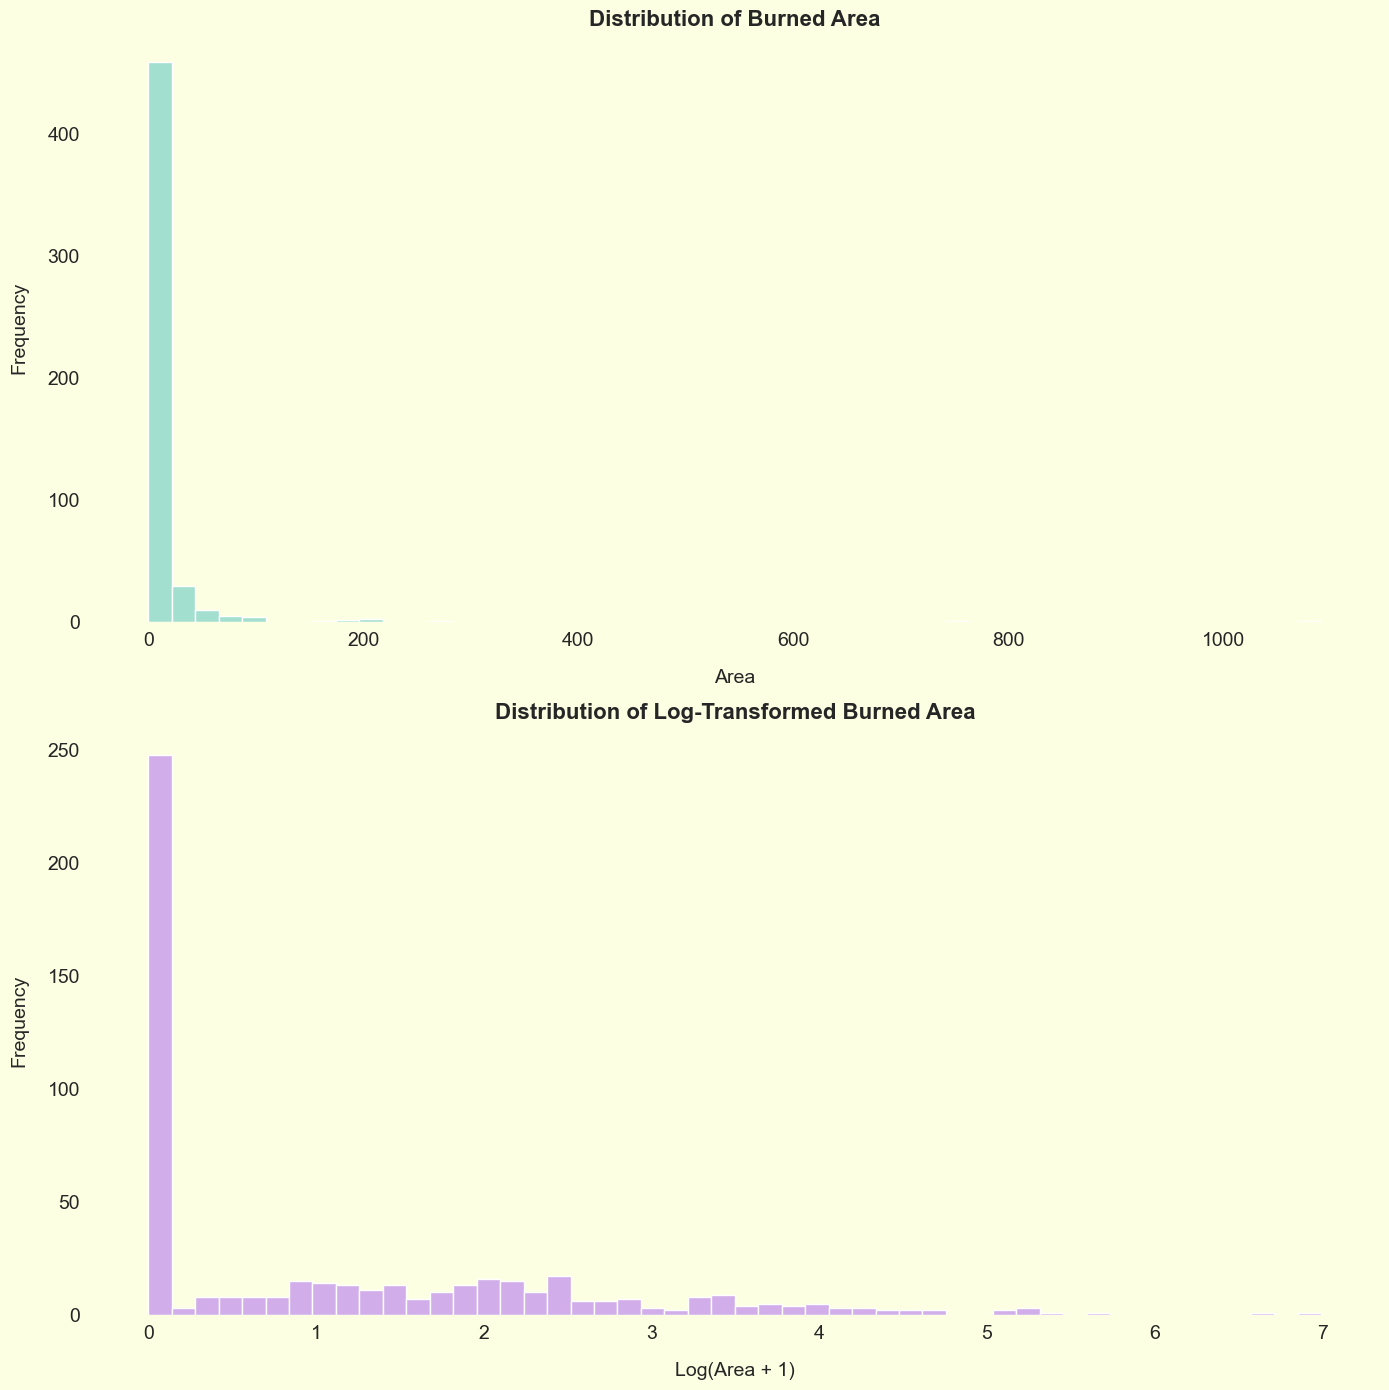

In [3]:
# Create figure and axes
fig, axes = plt.subplots(2, 1, figsize=(14, 14))

# Histogram for raw 'area'
sns.histplot(fires_df['area'], bins=50, kde=False, color="#85d5c8", ax=axes[0])
axes[0].set_title("Distribution of Burned Area")
axes[0].set_xlabel("Area")
axes[0].set_ylabel("Frequency")

# Histogram for log-transformed 'area'
sns.histplot(fires_df['log_area'], bins=50, kde=False, color="#c392ec", ax=axes[1])
axes[1].set_title("Distribution of Log-Transformed Burned Area")
axes[1].set_xlabel("Log(Area + 1)")
axes[1].set_ylabel("Frequency")

# Adjust layout
plt.tight_layout()
plt.show()

### Distribution Analysis of the Target Variable

---

I examined the distribution of the target variable `area` and its log-transformed version `log_area` using frequency bins and histograms.

**Original `area` distribution:**

- The distribution is extremely right-skewed.
- The majority of fires (≈95.7%) have very small burned areas within the first bin (0–54.5 hectares).
- Only a tiny fraction of observations fall in larger bins, with sporadic occurrences extending up to over 1,000 hectares.
- This highlights the presence of rare but extreme fire events in the dataset.

**Log-transformed `log_area` distribution:**

- The log transformation reduces skewness and spreads the values more evenly across bins.
- The first bin (≈0–0.35, corresponding roughly to area 0–0.42) still contains a large portion of fires (≈49%), but subsequent bins show a gradual and more interpretable decrease in frequency.
- The distribution after log transformation captures smaller, moderate, and larger fire events in a way that is easier to visualize and model.


## Categorical Distributions

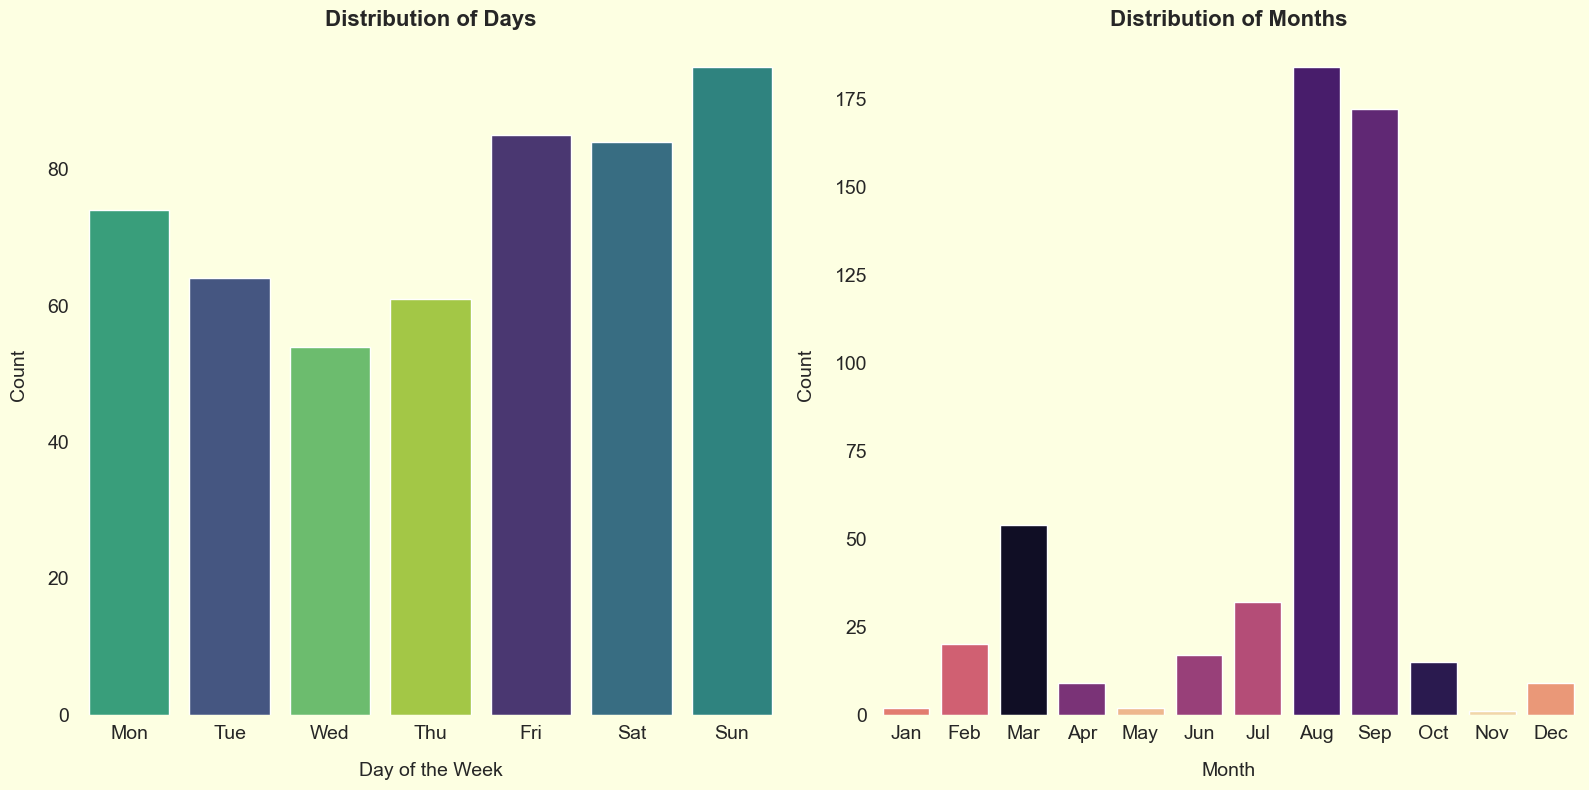

In [4]:
# List of categorical columns in the dataset
categorical_columns = ["month", "day"]

# Define the correct order for days and months (capitalized)
day_order = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
               "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Map lowercase values in the dataset to capitalized labels
fires_df["day"] = fires_df["day"].str.capitalize()
fires_df["month"] = fires_df["month"].str.capitalize()

# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Barplot for 'day' in chronological order
sns.countplot(
    x="day", 
    data=fires_df, 
    ax=axes[0], 
    palette="viridis", 
    hue="day", 
    legend=False, 
    order=day_order
)
axes[0].set_title("Distribution of Days")
axes[0].set_xlabel("Day of the Week")
axes[0].set_ylabel("Count")

# Barplot for 'month' in chronological order
sns.countplot(
    x="month", 
    data=fires_df, 
    ax=axes[1], 
    palette="magma", 
    hue="month", 
    legend=False, 
    order=month_order
)
axes[1].set_title("Distribution of Months")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Count")

# Adjust layout
plt.tight_layout()
plt.show()

### Analysis of Categorical Columns: `day` and `month`

---

The dataset contains two categorical variables that describe the time dimension of the forest fire records: **day of the week** and **month of the year**.

#### Day of the Week
- The distribution of fire occurrences is **not fully uniform**.  
- The highest counts are on **Sunday (95)** and **Friday (85)**, followed closely by **Saturday (84)**.  
- The lowest counts are on **Wednesday (54)** and **Thursday (61)**.  
- While the differences are not extreme, there is a **slight concentration of fires toward weekends**, which may relate to weather patterns or human activity.

#### Month of the Year
- The monthly distribution shows a **strong seasonal pattern**.  
- Fires occur most frequently during **August (184)** and **September (172)**, followed by **March (54)** and **July (32)**.  
- Very few fires are recorded in **winter months**: **January (2)** and **December (9)**.  
- Spring months (**April: 9, May: 2**) and late autumn (**November: 1**) also show minimal activity.  
- This confirms that **summer and early autumn** are the peak fire seasons, strongly tied to climate conditions such as heat and dryness.


## Distribution of Log-Transformed Burned Area by Day and Month

In [5]:
# Summary statistics for Day vs Log(Areas)
day_summary = fires_df.groupby("day")["log_area"].describe()
day_summary = day_summary[["count", "mean", "50%", "std", "min", "25%", "75%", "max"]]
day_summary.rename(columns={"50%": "median"}, inplace=True)

# Summary statistics for Month vs Log(Areas)
month_summary = fires_df.groupby("month")["log_area"].describe()
month_summary = month_summary[["count", "mean", "50%", "std", "min", "25%", "75%", "max"]]
month_summary.rename(columns={"50%": "median"}, inplace=True)

print("Summary for 'day':")
display(day_summary)
print("\nSummary for 'month':")
display(month_summary)

Summary for 'day':


,count,mean,median,std,min,25%,75%,max
day,,,,,,,,
Fri,85.000,0.970,0.285,1.211,0.000,0.000,1.942,3.791
Mon,74.000,1.090,0.550,1.337,0.000,0.000,1.950,5.633
Sat,84.000,1.226,0.259,1.611,0.000,0.000,2.145,6.996
Sun,95.000,1.124,0.000,1.429,0.000,0.000,2.055,5.286
Thu,61.000,1.026,0.642,1.317,0.000,0.000,1.783,6.616
Tue,64.000,1.231,0.500,1.482,0.000,0.000,2.287,5.365
Wed,54.000,1.114,0.565,1.383,0.000,0.000,1.914,5.230



Summary for 'month':


,count,mean,median,std,min,25%,75%,max
month,,,,,,,,
Apr,9.000,1.089,0.000,1.486,0.000,0.000,1.725,4.129
Aug,184.000,1.045,0.435,1.361,0.000,0.000,1.796,6.616
Dec,9.000,2.572,2.462,0.449,1.853,2.329,2.937,3.249
Feb,20.000,1.088,0.371,1.292,0.000,0.000,2.014,3.966
Jan,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Jul,32.000,1.084,0.698,1.419,0.000,0.000,1.997,5.633
Jun,17.000,0.843,0.000,1.208,0.000,0.000,1.433,4.267
Mar,54.000,0.773,0.000,1.193,0.000,0.000,1.388,3.634
May,2.000,1.838,1.838,2.599,0.000,0.919,2.757,3.676


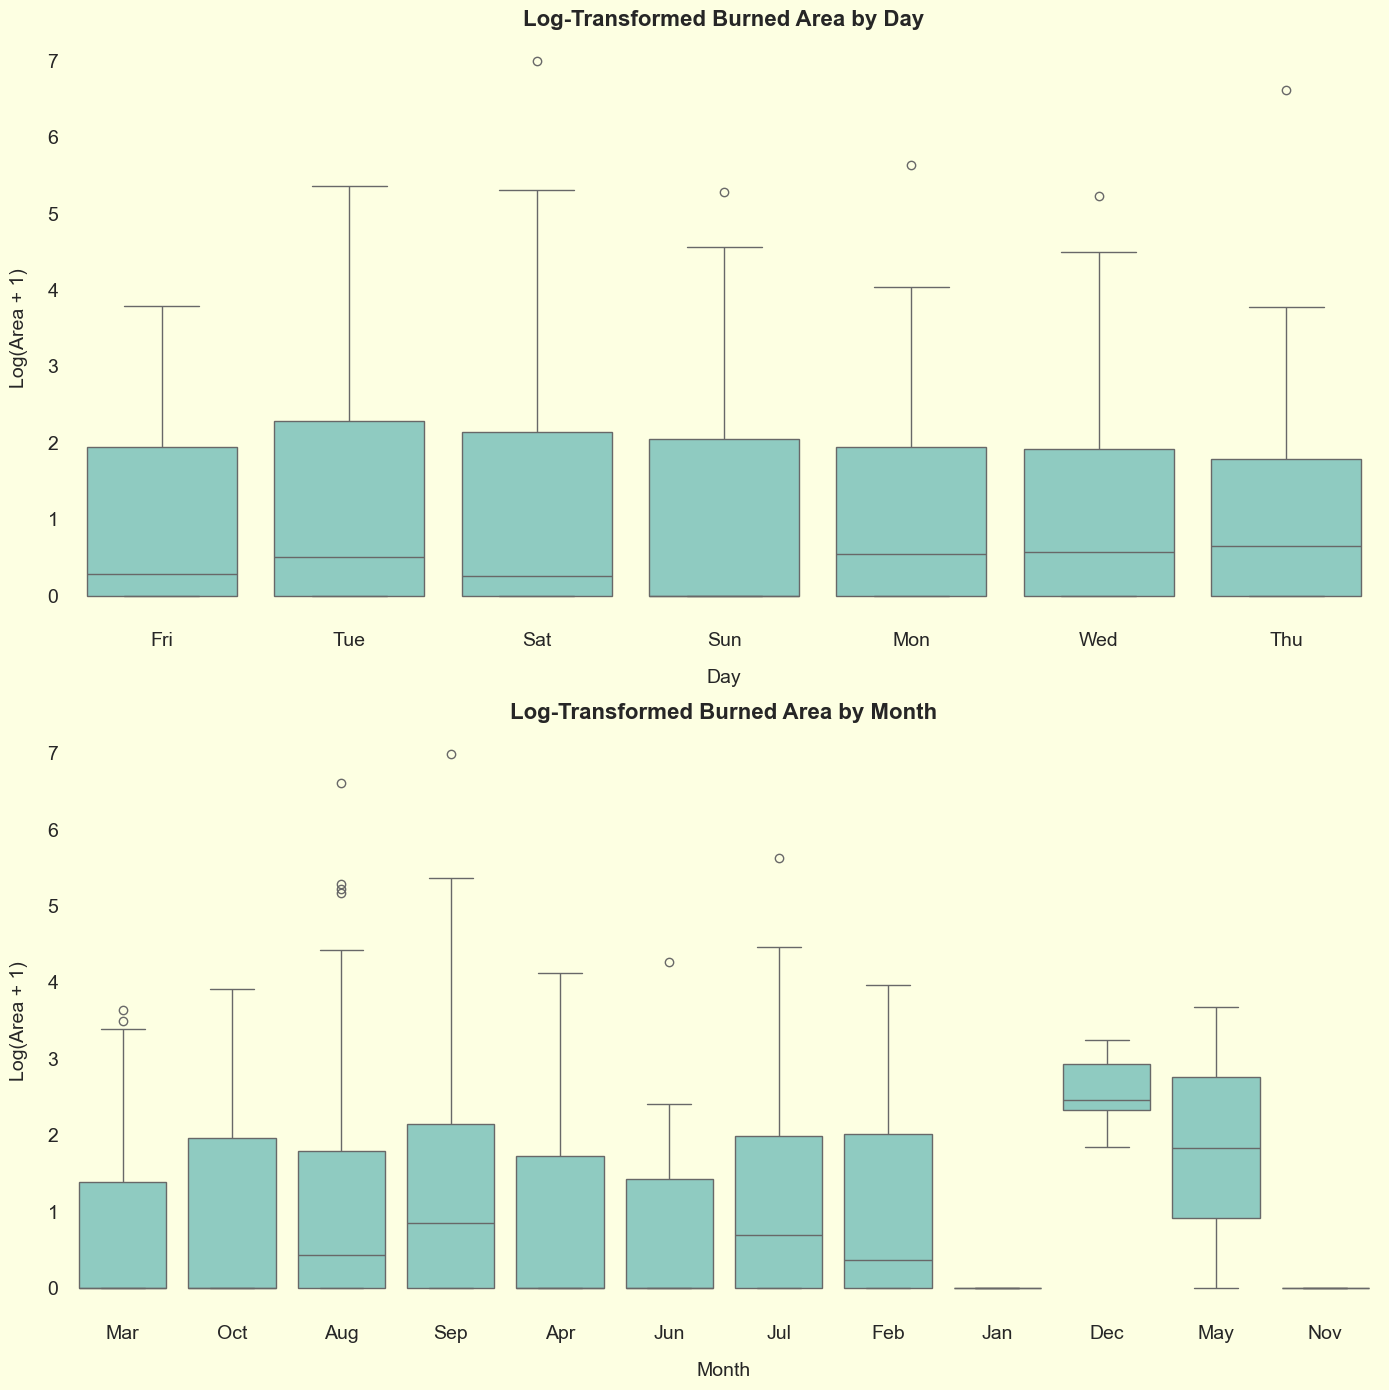

In [6]:
# Create a figure
fig, axes = plt.subplots(2, 1, figsize=(14, 14))

# Boxplot: Day vs Log(Areas)
sns.boxplot(data=fires_df, x="day", y="log_area", ax=axes[0], color="#85d5c8")
axes[0].set_title("Log-Transformed Burned Area by Day")
axes[0].set_xlabel("Day")
axes[0].set_ylabel("Log(Area + 1)")

# Boxplot: Month vs Log(Areas)
sns.boxplot(data=fires_df, x="month", y="log_area", ax=axes[1], color="#85d5c8")
axes[1].set_title("Log-Transformed Burned Area by Month")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Log(Area + 1)")

# Adjust layout
plt.tight_layout()
plt.show()

### Analysis of Log-Transformed Burned Area by Day and Month

---

#### Day of the Week
The summary statistics for `log_area` across different days of the week reveal some interesting patterns:

- **Median values** are low for most days, with Sunday having the lowest median (0.0), indicating that on many days no significant fire area is recorded.  
- **Mean values** are slightly higher than the medians, suggesting that some days experience a few extreme fire events. Tuesday (mean ≈ 1.23) and Saturday (mean ≈ 1.23) show the highest average log-transformed burned area.  
- **Variability** (std) is fairly consistent across days, ranging from ~1.21 to ~1.61. Saturday has the highest standard deviation, highlighting more inconsistent fire activity.  
- **Maximum values** indicate outliers on all days, with Saturday (≈6.996) and Monday (≈5.633) experiencing the largest single fire events.  

Overall, the distribution shows that fires are generally small on most days, but occasional extreme events skew the averages, particularly on weekends and early weekdays.

---

#### Month
The monthly summary provides insight into seasonal patterns:

- **High fire activity** is evident in August and September, with mean log_area values of 1.045 and 1.275, and median values well above 0, indicating more consistent fire events during late summer.  
- **Winter and early spring months** (Jan, Nov, Dec) show very low median burned areas, often 0, reflecting minimal fire occurrences. December is an exception with a small sample size but higher log_area (mean ≈ 2.57) due to a few extreme events.  
- **Variability** is largest in May and September, reflecting sporadic extreme fire events. May shows a particularly high standard deviation (~2.60) despite only two observations, indicating a single large fire significantly affecting the statistics.  
- **Outliers** are present in almost all months, particularly in summer and early fall, confirming that extreme fire events dominate the burned area distribution.  


## Numerical Distributions

In [7]:
# List of numerical columns in the dataset
numerical_columns = ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']

# Create a dataframe with summary statistics
summary_df = fires_df[numerical_columns].describe().T

# Calculate IQR and outlier bounds
summary_df["IQR"] = summary_df["75%"] - summary_df["25%"]
summary_df["Lower Bound"] = summary_df["25%"] - 1.5 * summary_df["IQR"]
summary_df["Upper Bound"] = summary_df["75%"] + 1.5 * summary_df["IQR"]

# Display the summary statistics
display(summary_df)

,count,mean,std,min,25%,50%,75%,max,IQR,Lower Bound,Upper Bound
X,517.000,4.669,2.314,1.000,3.000,4.000,7.000,9.000,4.000,-3.000,13.000
Y,517.000,4.300,1.230,2.000,4.000,4.000,5.000,9.000,1.000,2.500,6.500
FFMC,469.000,90.580,5.698,18.700,90.200,91.600,92.800,96.200,2.600,86.300,96.700
DMC,496.000,111.195,64.008,1.100,70.800,108.300,141.575,291.300,70.775,-35.363,247.738
DC,474.000,550.673,246.061,7.900,441.200,664.500,713.900,860.600,272.700,32.150,1122.950
ISI,515.000,9.019,4.565,0.000,6.450,8.400,10.750,56.100,4.300,0.000,17.200
temp,496.000,18.885,5.748,2.200,15.475,19.300,22.725,33.300,7.250,4.600,33.600
RH,487.000,44.382,16.180,15.000,33.000,42.000,53.500,100.000,20.500,2.250,84.250
wind,482.000,4.022,1.794,0.400,2.700,4.000,4.900,9.400,2.200,-0.600,8.200
rain,485.000,0.023,0.306,0.000,0.000,0.000,0.000,6.400,0.000,0.000,0.000


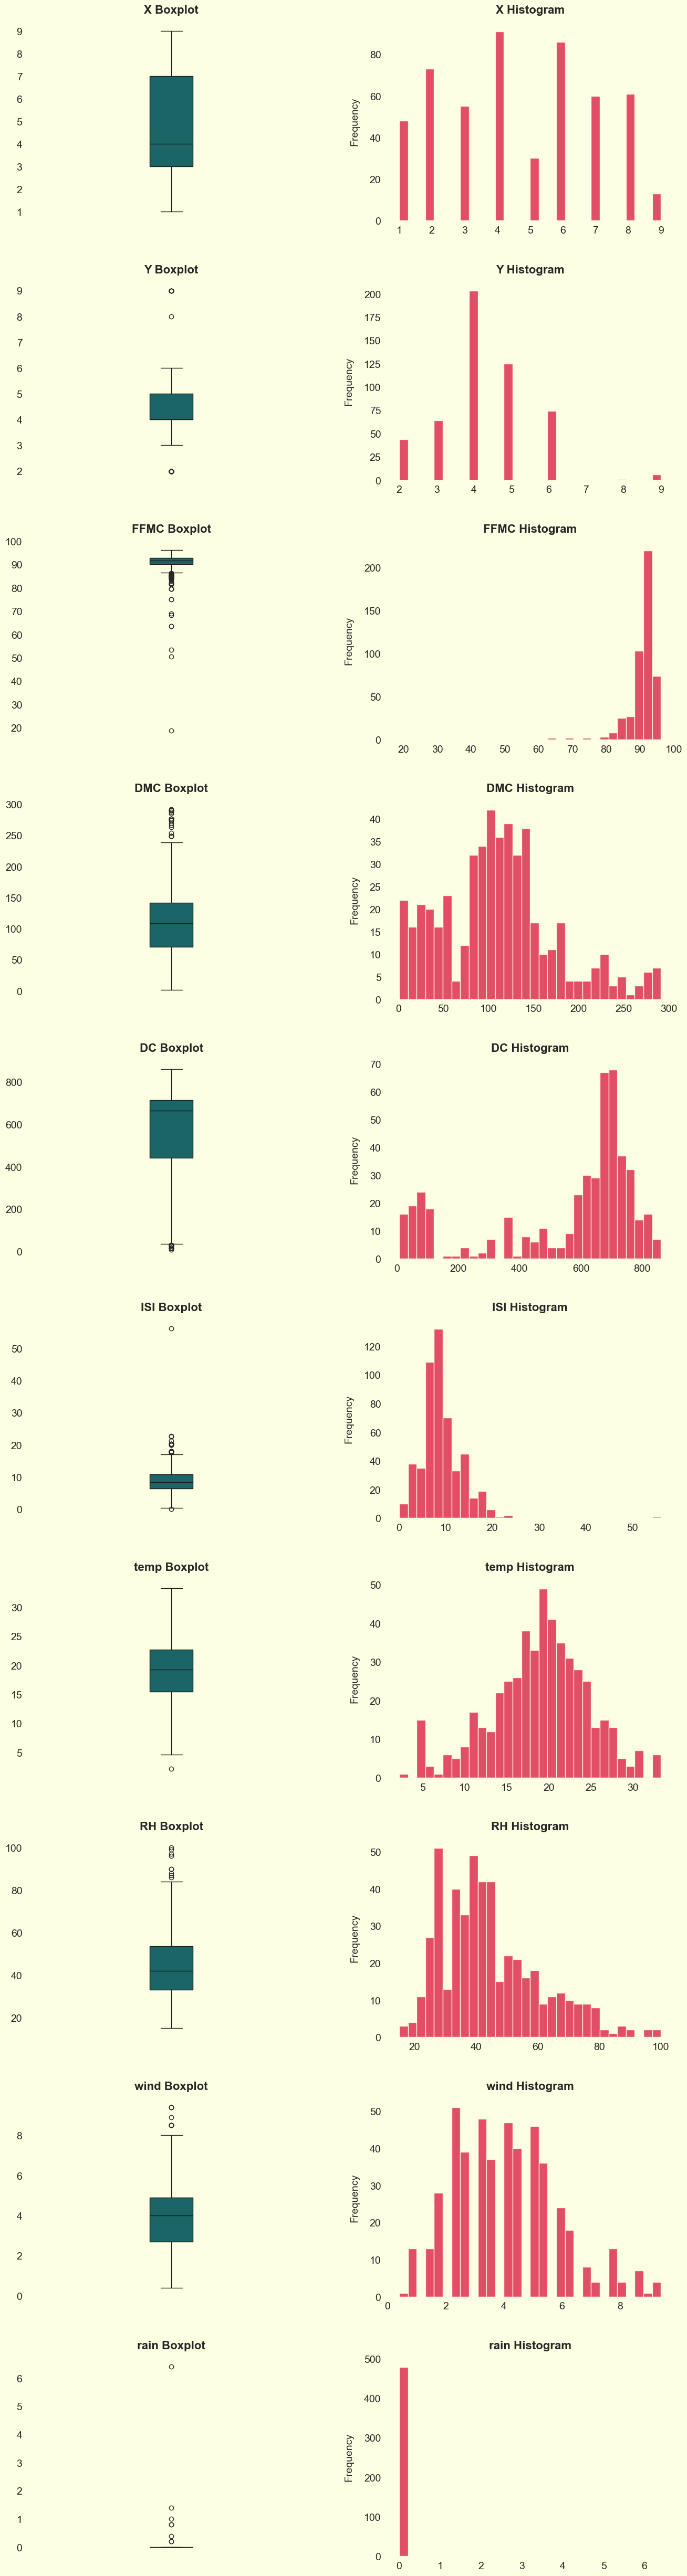

In [8]:
# Set up subplots: 10 variables → 10 rows × 2 columns (boxplot + histogram)
fig, axes = plt.subplots(nrows=len(numerical_columns), ncols=2, figsize=(14, 50))

# Flatten axes for easy iteration
for i, col in enumerate(numerical_columns):
    
    # --- Boxplot ---
    sns.boxplot(
        data=fires_df, y=col, ax=axes[i, 0], color='#0F7173', width=.15,
        boxprops=dict(edgecolor="#1a1a1a"),
        medianprops=dict(color="#1a1a1a"),
        whiskerprops=dict(color="#1a1a1a"),
        capprops=dict(color="#1a1a1a")
    )
    axes[i, 0].set_title(f"{col} Boxplot", pad=12)
    axes[i, 0].set_ylabel("")
    axes[i, 0].set_xlabel("")

    # --- Histogram ---
    axes[i, 1].hist(fires_df[col], bins=30, color="#DF3B57", edgecolor="#FDFFE2", alpha=.9)
    axes[i, 1].set_title(f"{col} Histogram", pad=12)
    axes[i, 1].set_ylabel("Frequency")
    axes[i, 1].set_xlabel("")

# Adjust layout
plt.tight_layout(pad=4)
plt.show()

### Analysis of Numerical Distributions

---

- **X and Y (spatial coordinates)**  
  Both X and Y are uniformly distributed integers within a limited range. They don’t show extreme skewness but have some concentration at certain points, likely reflecting the layout of the forest grid.

- **FFMC, DMC, DC, and ISI (fire weather indices)**  
  - **FFMC** values are tightly clustered at the high end, indicating that most days had dry conditions suitable for fire spread.  
  - **DMC** and **DC** have right-skewed distributions, with a few very high values. This suggests that while many days have moderate values, occasionally the conditions were extreme.  
  - **ISI** is also right-skewed, with most values near the lower end but occasional high spikes.

- **Temperature (temp)**  
  The distribution is roughly bell-shaped, centered around mild to warm values. Outliers exist at higher temperatures, which are important for fire risk.

- **Relative Humidity (RH)**  
  RH is left-skewed, with most observations concentrated at higher humidity levels. However, lower RH outliers (drier conditions) may be especially relevant for fire occurrence.

- **Wind**  
  Wind speeds are concentrated at the lower end, with very few extreme values. The distribution indicates most days had light winds, though rare higher values might strongly influence fire spread.

- **Rain**  
  Rainfall is highly skewed with the majority of observations being zero, reflecting many dry days. A small number of heavy rainfall events create long tails in the distribution.

---

**Key Observations**  
- Many meteorological variables (DMC, DC, ISI, Rain) are heavily skewed, highlighting that extreme conditions are rare but impactful.  
- Outliers, especially in **Rain** and **Fire Weather Indices**, may strongly affect modeling and should be considered carefully (e.g., log-transformations or robust models).  
- **Temperature** and **Relative Humidity** show more natural environmental variation, with clear patterns that align with expected weather distributions.


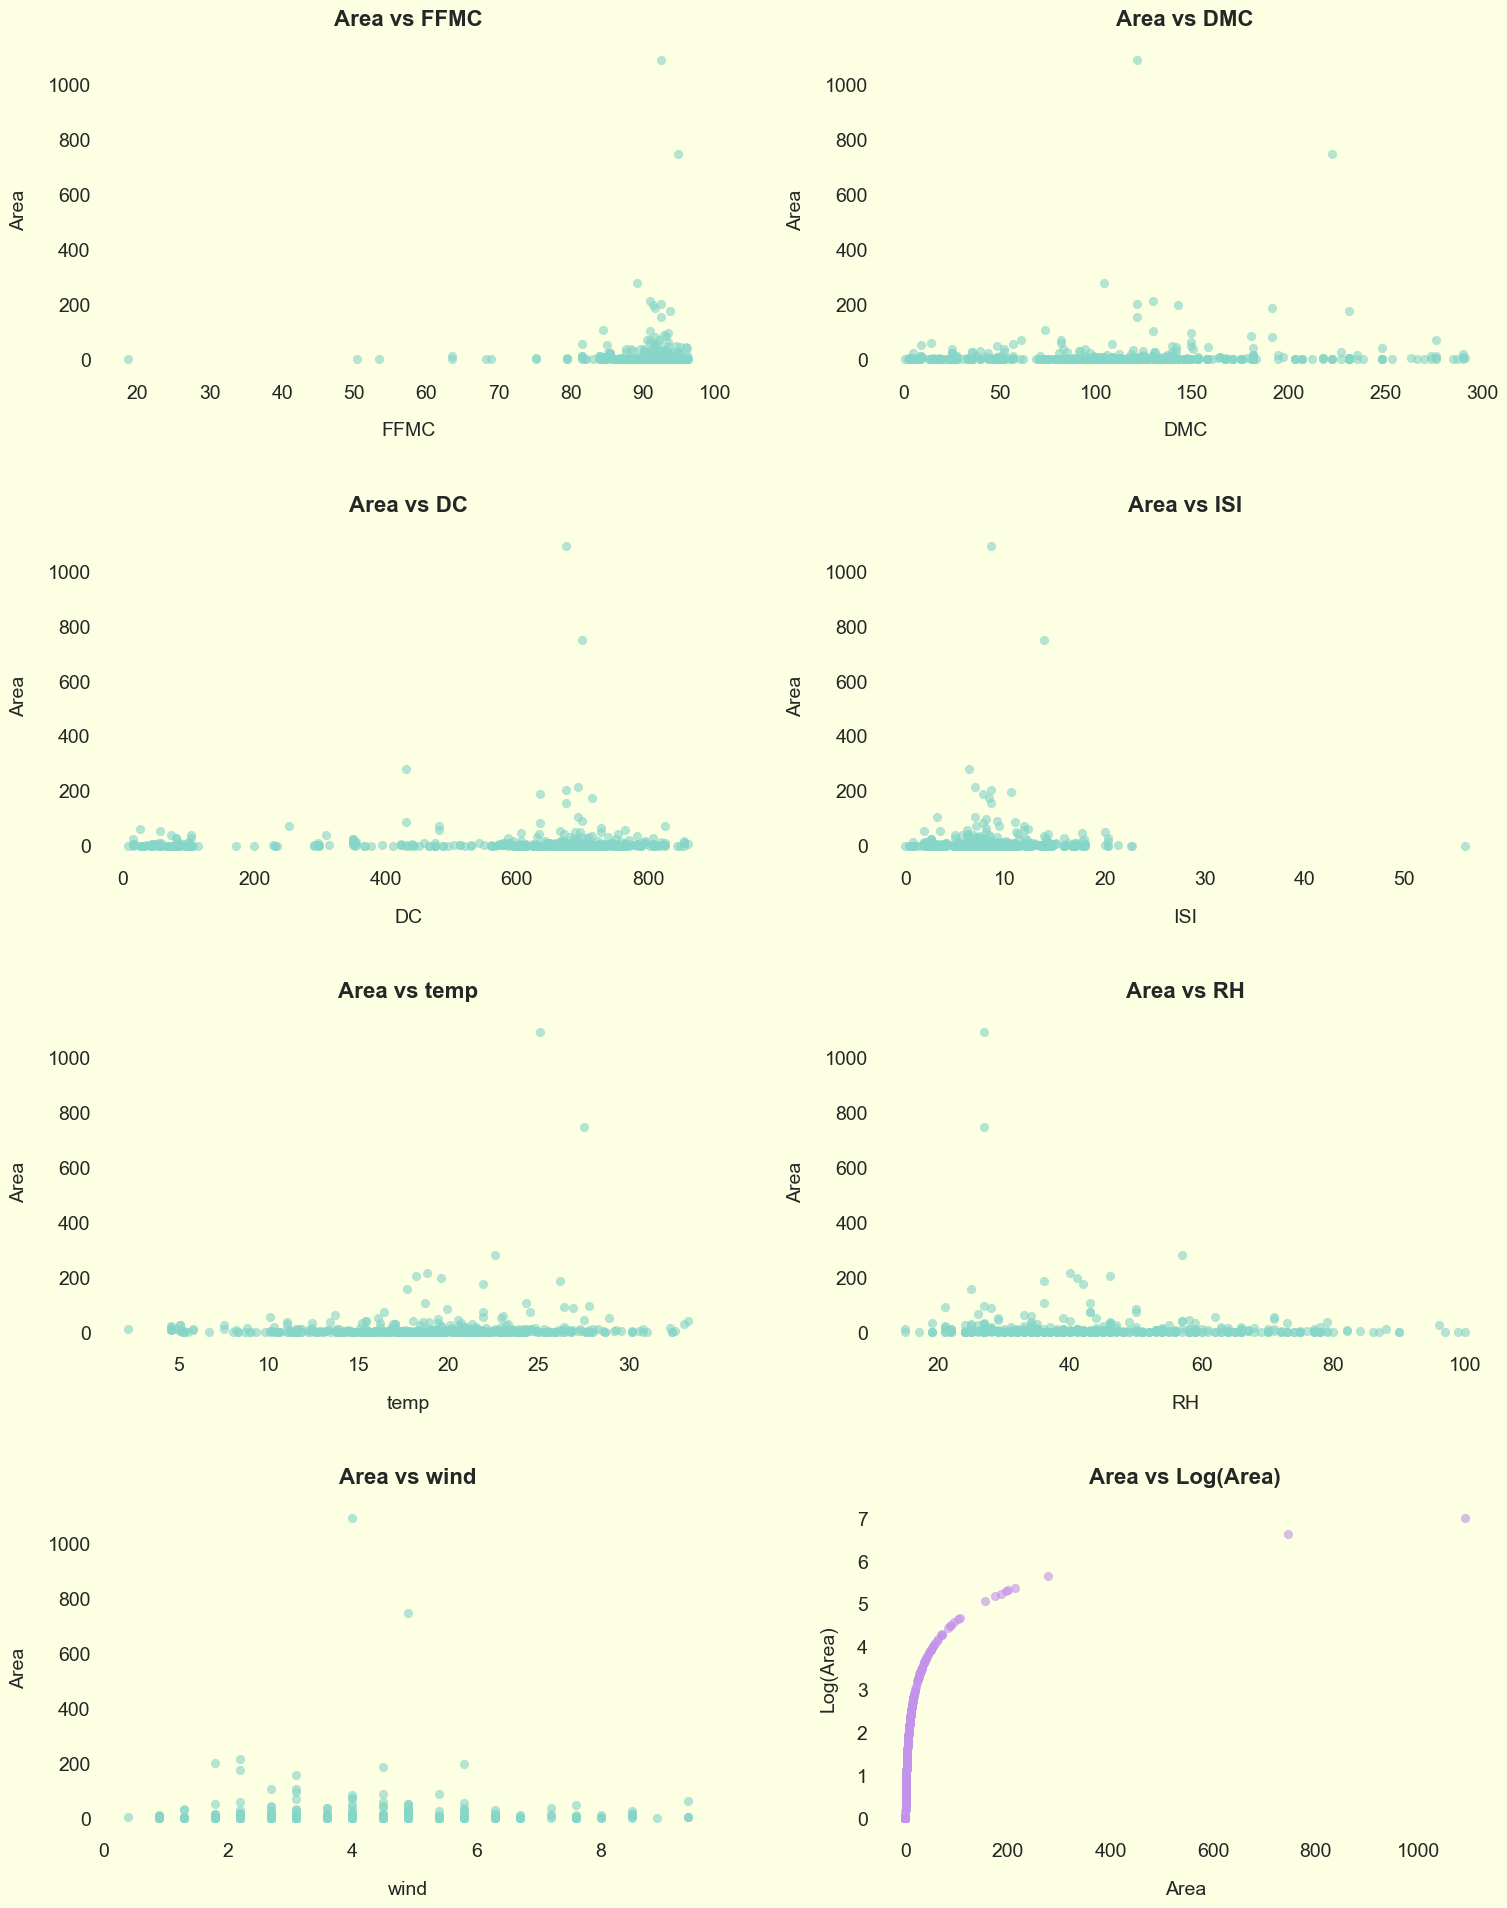

In [9]:
# Select predictors to explore
predictors = ["FFMC", "DMC", "DC", "ISI", "temp", "RH", "wind"]

# Set up subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 20))
axes = axes.flatten()

# Plot scatterplots for area
for i, col in enumerate(predictors):
    ax = axes[i]
    sns.scatterplot(
        data=fires_df, x=col, y="area", 
        ax=ax, alpha=0.6, edgecolor=None, color="#85d5c8"
    )
    ax.set_title(f"Area vs {col}", pad=14)
    ax.set_ylabel("Area")
    ax.set_xlabel(col)

# Last slot: area vs log_area for comparison
sns.scatterplot(
    data=fires_df, x="area", y="log_area", 
    ax=axes[-1], alpha=0.6, edgecolor=None, color="#c392ec"
)
axes[-1].set_title("Area vs Log(Area)", pad=14)
axes[-1].set_ylabel("Log(Area)")
axes[-1].set_xlabel("Area")

plt.tight_layout(pad=4)
plt.show()

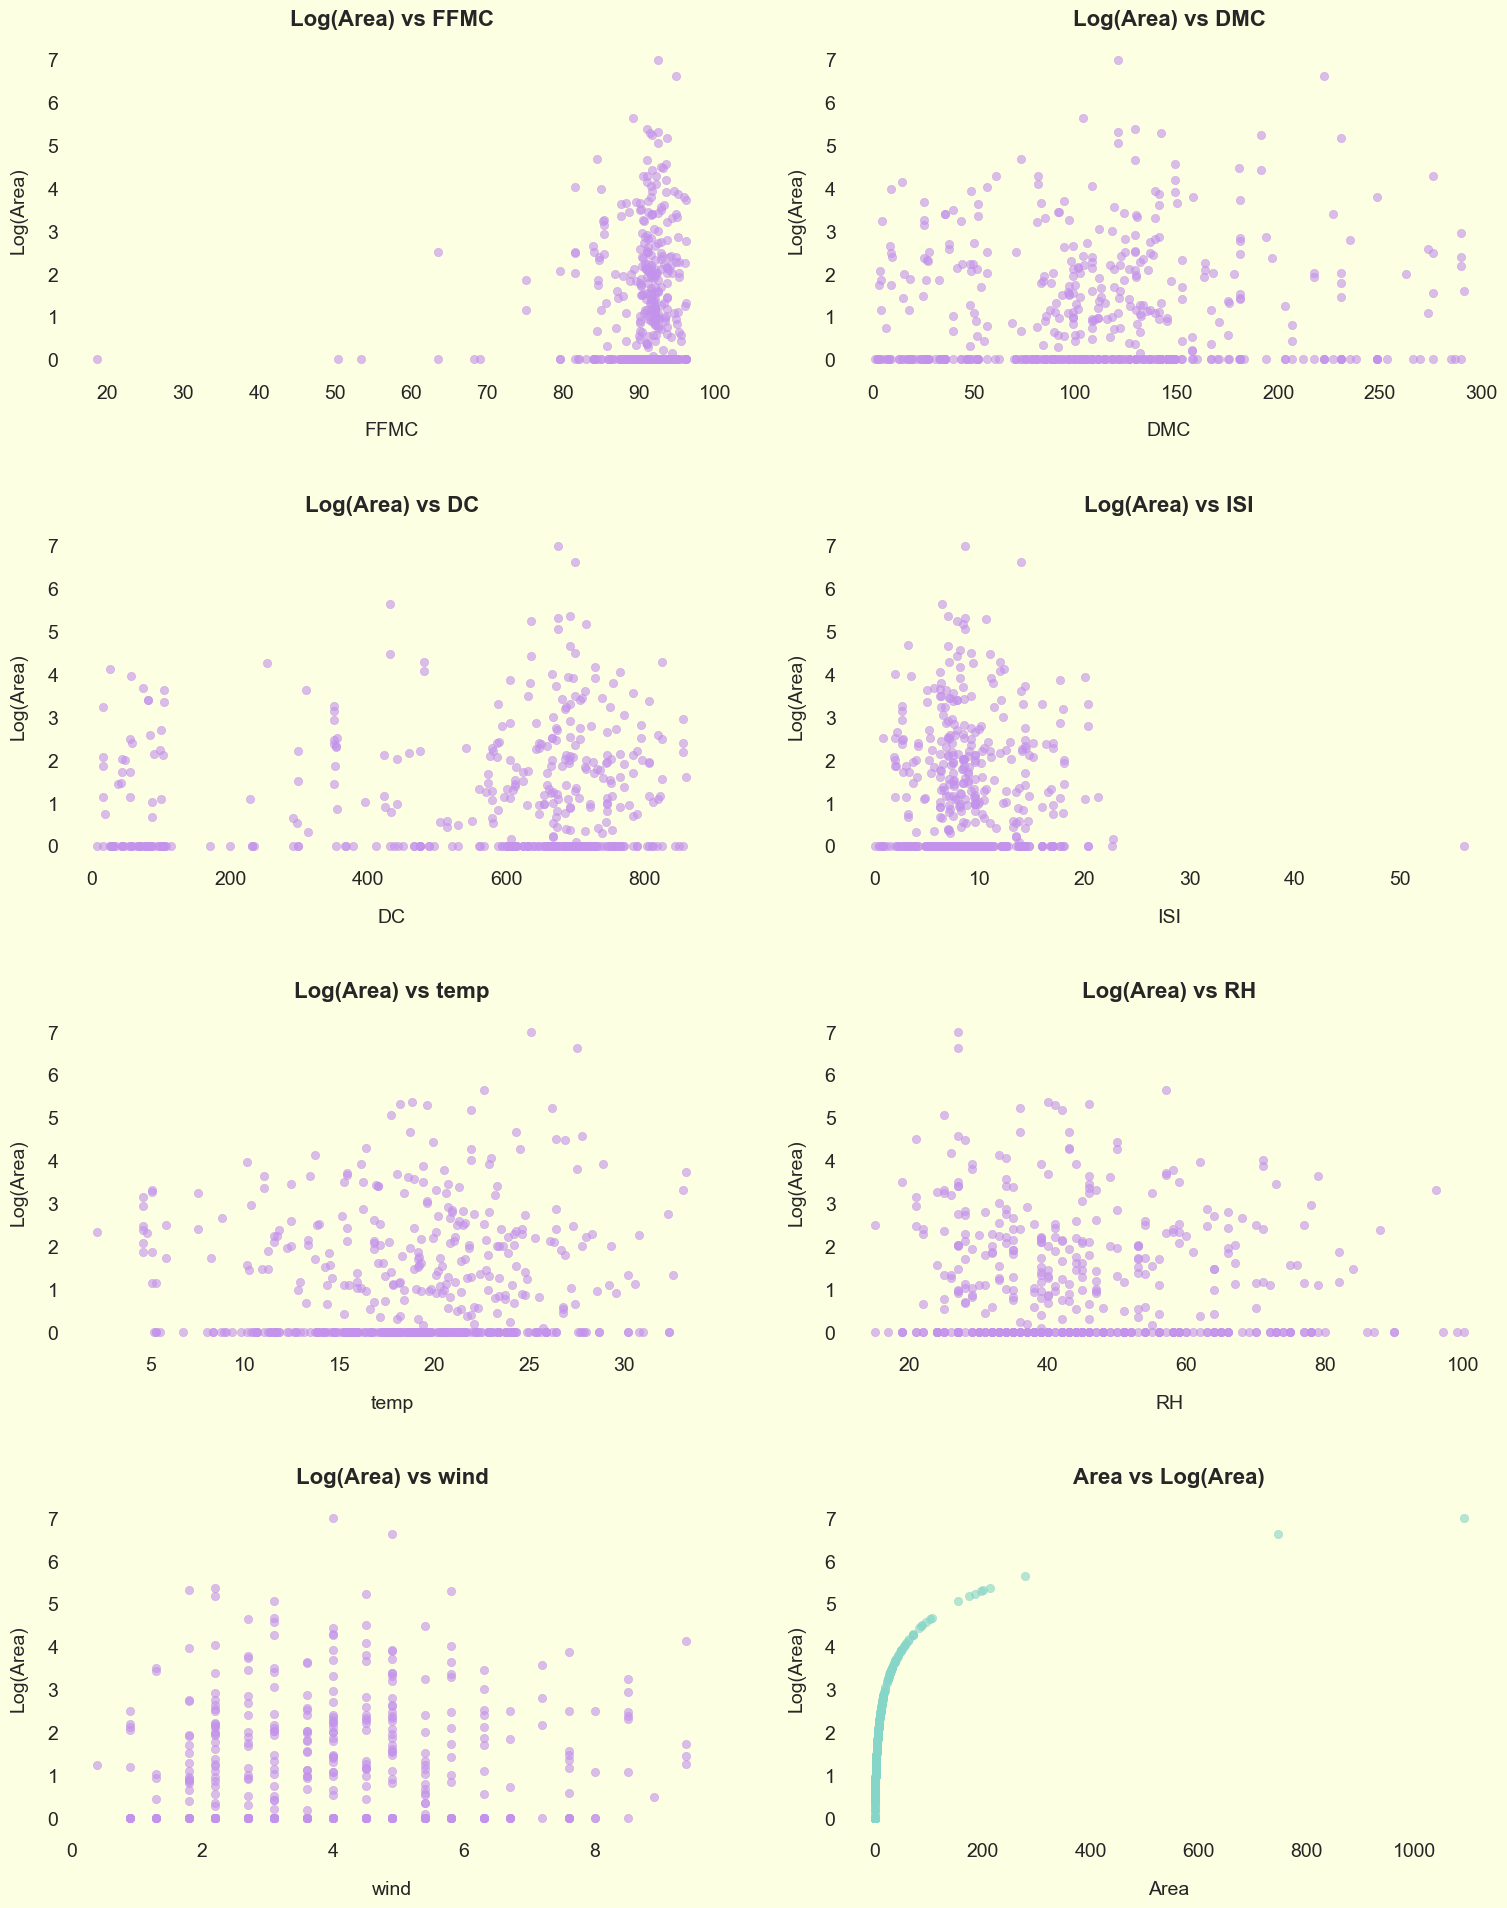

In [10]:
# Set up subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 20))
axes = axes.flatten()

# Plot scatterplots for log_area
for i, col in enumerate(predictors):
    ax = axes[i]
    sns.scatterplot(
        data=fires_df, x=col, y="log_area",
        ax=ax, alpha=0.6, edgecolor=None, color="#c392ec"
    )
    ax.set_title(f"Log(Area) vs {col}", pad=14)
    ax.set_ylabel("Log(Area)")
    ax.set_xlabel(col)

# Last slot: area vs log_area for comparison
sns.scatterplot(
    data=fires_df, x="area", y="log_area",
    ax=axes[-1], alpha=0.6, edgecolor=None, color="#85d5c8"
)
axes[-1].set_title("Area vs Log(Area)", pad=14)
axes[-1].set_ylabel("Log(Area)")
axes[-1].set_xlabel("Area")

plt.tight_layout(pad=4)
plt.show()

## Scatterplot Analysis: Area vs Log(Area)

---

### Raw `area` relationships
- **Heavy skewness:** Most data points cluster near zero across all predictors, making it difficult to see trends.
- **Outliers dominate:** A few extreme fire areas (hundreds of hectares) stretch the y-axis and obscure the main cloud of points.
- **Flat appearance:** Variables like FFMC, DMC, DC, ISI, temperature, RH, and wind show no obvious linear relation with raw `area`. This is expected due to the heavy-tailed distribution.

### `log_area` relationships
- **Improved spread:** Log transformation compresses extreme outliers and expands the lower range, revealing more structure.
- **FFMC, DMC, DC, ISI:** Weak upward trends are visible — higher fire weather indices tend to associate with larger `log_area`.
- **Temperature:** Slight positive relationship; warmer conditions might support larger fires.
- **Relative Humidity (RH):** Tendency toward a negative relationship — higher humidity is generally linked with smaller fires.
- **Wind:** Scatter shows more vertical spread, but no clear pattern; effect might be nonlinear or interact with other variables.

### Takeaways
- Raw `area` is too skewed for meaningful direct scatterplots.
- `log_area` provides a clearer view, showing weak but interpretable trends with weather indices, temperature, and humidity.
- These patterns suggest that modeling `log_area` instead of raw `area` will likely yield better predictive performance and interpretability.


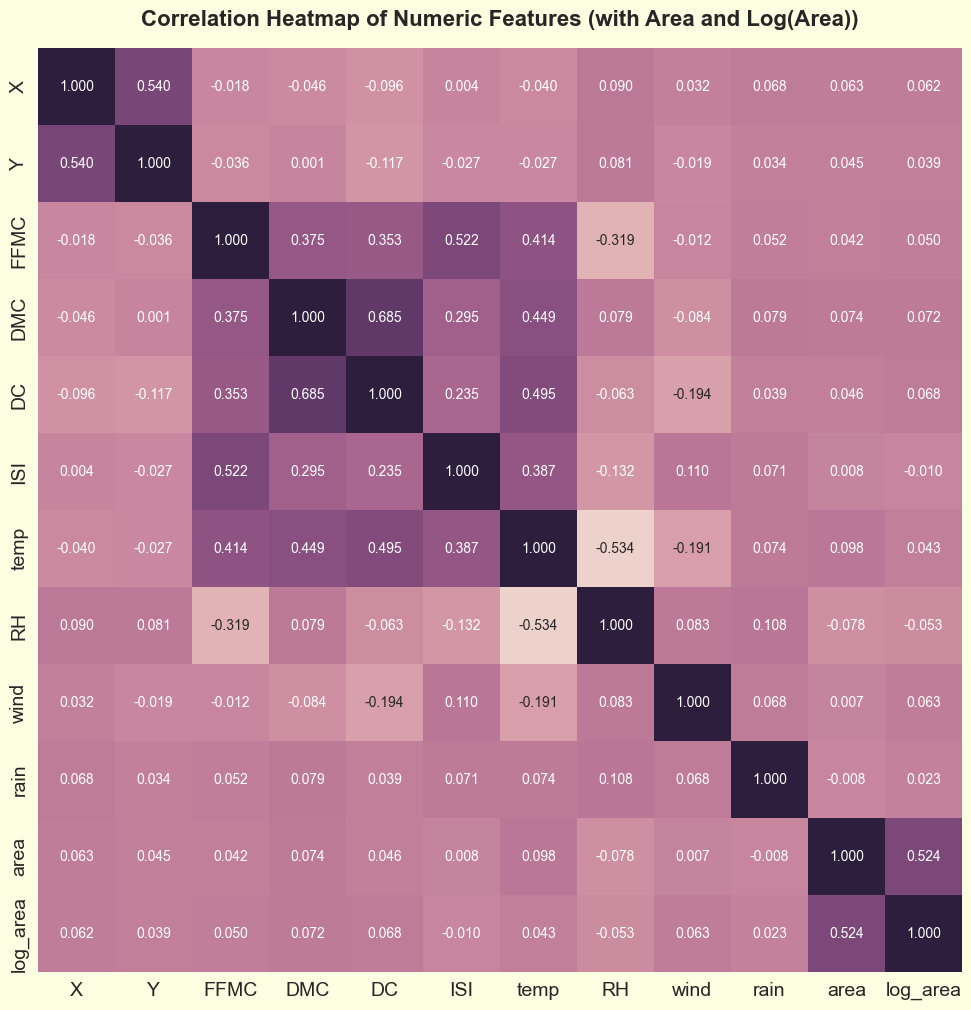

In [11]:
# Create correlation matrix including both 'area' and 'log_area'
corr_matrix = fires_df[['X','Y','FFMC','DMC','DC','ISI','temp','RH','wind','rain','area','log_area']].corr()

# Plot heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(
    corr_matrix, 
    annot=True, fmt=".3f", cmap=sns.cubehelix_palette(as_cmap=True), 
    cbar=False, square=True, linewidths=0
)
plt.title("Correlation Heatmap of Numeric Features (with Area and Log(Area))", pad=16)
plt.show()

### Correlation Analysis of Numeric Features (including `area` and `log_area`)

---

#### Target Variables: `area` vs `log_area`
- **Raw `area`:**
  - Shows only very weak correlations with predictors (highest: `temp` at **0.10**).
  - This confirms that the raw target is dominated by skewness and outliers, which masks potential relationships.

- **Log-transformed `area`:**
  - Correlations are slightly clearer but still weak (all ≤ **0.07** with predictors).
  - The strongest correlation remains with the raw `area` itself (**0.52**), as expected.
  - Even though correlations are low, scatterplots suggested that `log_area` provides a more interpretable spread, especially for `FFMC`, `DMC`, `DC`, `ISI`, and `RH`.

#### Key Takeaways
- Fire indices are highly interrelated, as expected from their shared system design.
- Temperature and relative humidity are strongly (and inversely) related, reflecting climate conditions that influence fires.
- Both `area` and `log_area` have weak linear correlations with predictors. However, the **log transformation reduces skewness**, making patterns more visible in scatterplots despite low correlation coefficients.
- Predictive models may need to capture **nonlinear relationships and interactions** (e.g., using tree-based models or regularized regressions) rather than relying on linear associations alone.


## Data Preprocessing

## Missing Values

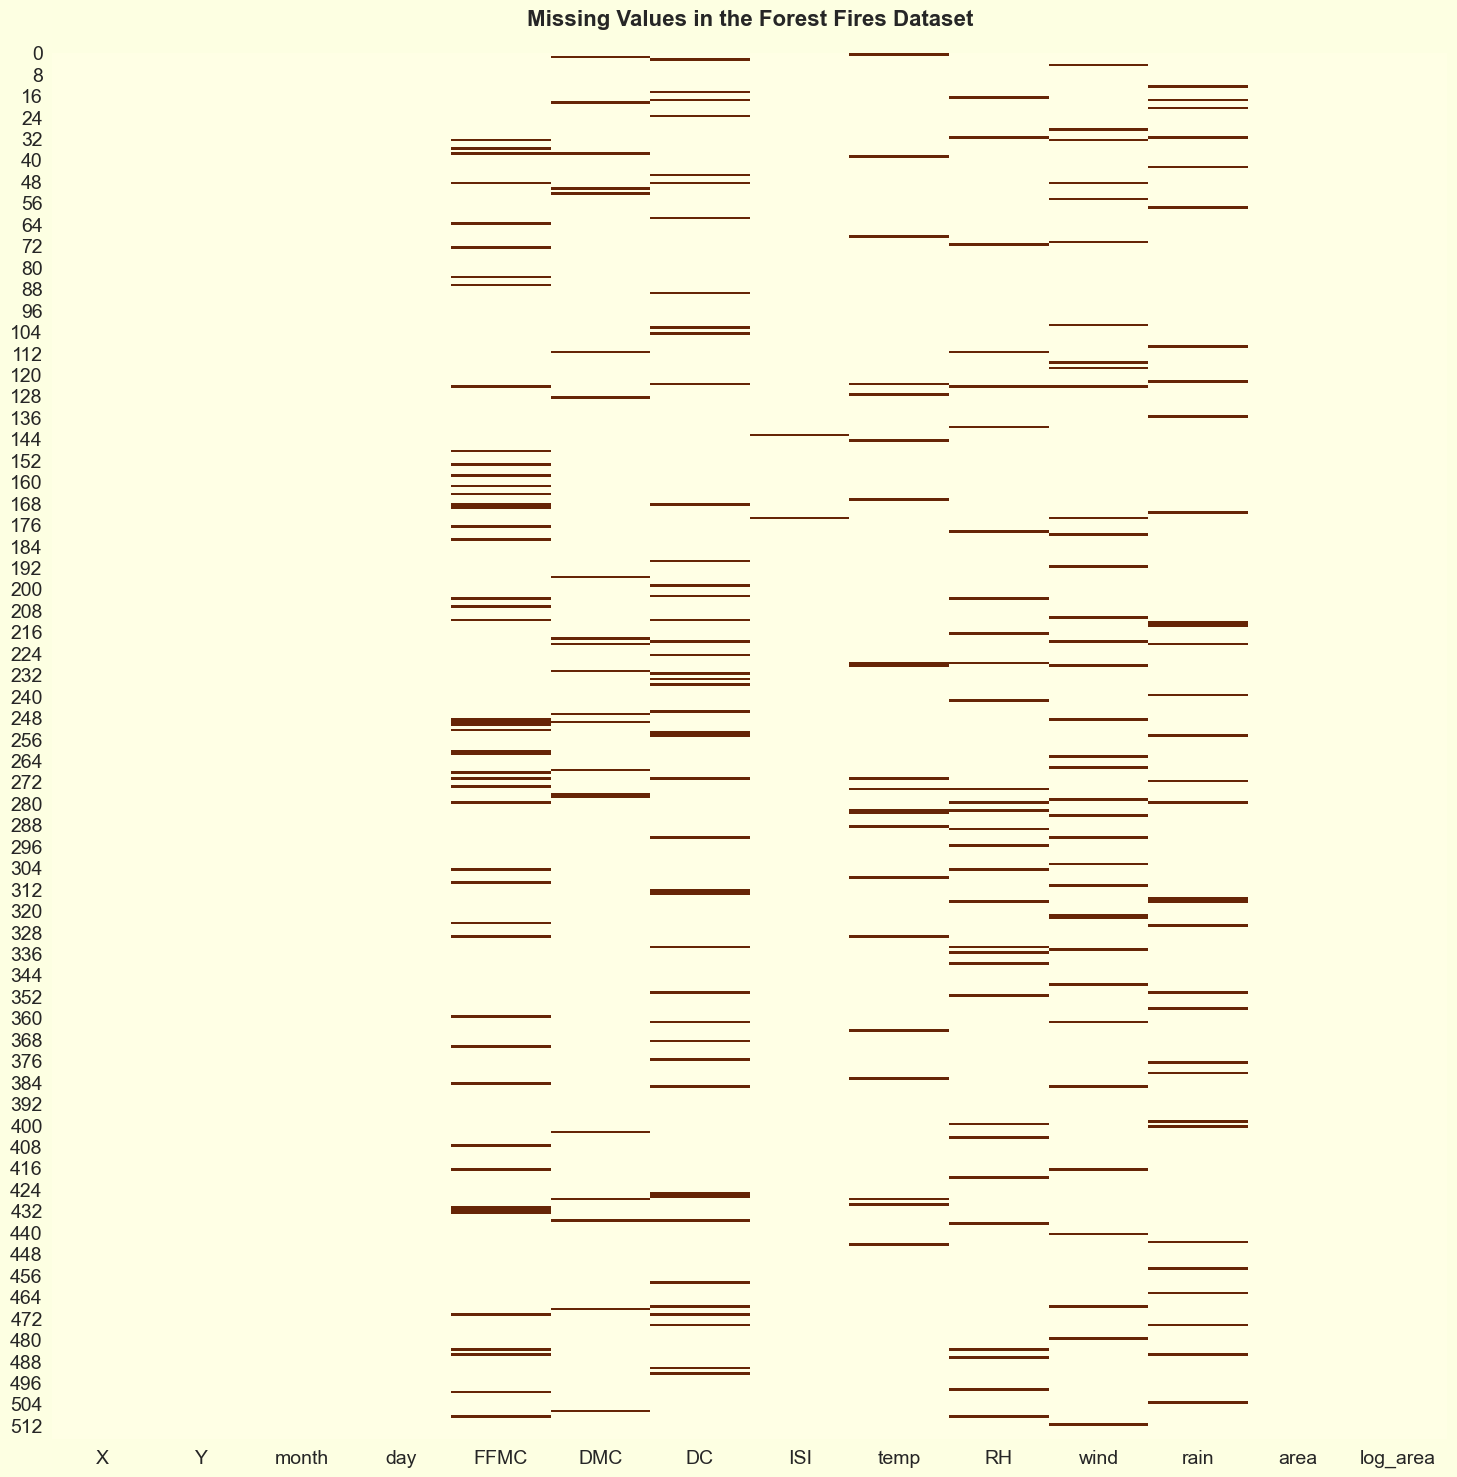

In [12]:
# Visualize missing values with a heatmap
plt.figure(figsize=(18, 18))
sns.heatmap(fires_df.isnull(), cbar=False, cmap=sns.color_palette("YlOrBr", as_cmap=True))
plt.title("Missing Values in the Forest Fires Dataset", pad=20)
plt.show()

### Missing Values Exploration

---

I examined the dataset for **missing values**.  
I plotted a Seaborn heatmap of `isnull()` to scan for patterns. The missing cells are **sprinkled across rows and features** without clear blocks by time, location, or variable. In short, **no strong pattern**—the gaps look mostly random, which supports using an imputation method that leverages nearby samples.

---

### Imputation Plan: KNNImputer (numeric-only)

- I’ll impute **only numeric features** with **KNNImputer** so that estimates come from “similar” records.  
- Because KNN uses distances, I will **standardize numeric features before imputation** (so large-range variables like `DC` don’t dominate).  
- Categorical features (`month`, `day`) have no missing values and are left as-is.  
- The target `area` will not be imputed.


In [13]:
# Config
rng = np.random.default_rng(42)
mask_frac = 0.1        # fraction of observed numeric entries to hide in each trial
n_trials  = 5          # repeat masking to stabilize the estimate
param_grid = {         # search space for the imputer only
    "n_neighbors": [3, 5, 7, 9, 11],
    "weights": ["uniform", "distance"]
}

# Score one (n_neighbors, weights) with mask-and-reconstruct RMSE ----
def score_imputer(X_num, n_neighbors, weights):
    pipe = Pipeline([
        ("scale", StandardScaler()),
        ("impute", KNNImputer(n_neighbors=n_neighbors, weights=weights))
    ])
    rmses = []
    # trials
    for _ in range(n_trials):
        X = X_num.copy()
        
        # indices of observed cells
        observed = np.argwhere(~np.isnan(X))
        
        # pick cells to hide
        k = int(np.floor(mask_frac * len(observed)))
        take_idx = rng.choice(len(observed), size=k, replace=False)
        rows, cols = observed[take_idx].T
        
        # stash true values, then mask them
        true_vals = X[rows, cols].copy()
        X[rows, cols] = np.nan

        # fit on partially-masked data and reconstruct
        X_imp = pipe.fit_transform(X)
        preds = X_imp[rows, cols]

        # RMSE on masked cells
        rmse = np.sqrt(np.mean((preds - true_vals)**2))
        rmses.append(rmse)
        
    return float(np.mean(rmses))

# Grid search over imputer params (numeric-only)
X_num = fires_df[numerical_columns].to_numpy(dtype=float)
best = None
results = []

for n_neighbors, weights in product(param_grid["n_neighbors"], param_grid["weights"]):
    rmse = score_imputer(X_num, n_neighbors, weights)
    results.append({"n_neighbors": n_neighbors, "weights": weights, "rmse": rmse})
    if (best is None) or (rmse < best["rmse"]):
        best = {"n_neighbors": n_neighbors, "weights": weights, "rmse": rmse}

results_df = pd.DataFrame(results).sort_values("rmse")
print("Imputer CV (lower is better):")
display(results_df)

print(f"\nBest params -> n_neighbors={best['n_neighbors']}, weights='{best['weights']}', RMSE={best['rmse']:.4f}")

# Fit the final scaler+imputer on real data (with true NaNs) and transform
final_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("impute", KNNImputer(n_neighbors=best["n_neighbors"], weights=best["weights"]))
])

fires_df[numerical_columns] = final_pipe.fit_transform(fires_df[numerical_columns])

# Check the results
assert fires_df[numerical_columns].isna().sum().sum() == 0
print("Numeric NaNs after final impute:", fires_df[numerical_columns].isna().sum().sum())

Imputer CV (lower is better):


,n_neighbors,weights,rmse
5,7,distance,186.541
0,3,uniform,188.232
6,9,uniform,188.338
4,7,uniform,189.388
3,5,distance,191.441
1,3,distance,195.383
7,9,distance,198.055
9,11,distance,198.381
2,5,uniform,207.003
8,11,uniform,209.466



Best params -> n_neighbors=7, weights='distance', RMSE=186.5411
Numeric NaNs after final impute: 0


### Handling Missing Values with Optimized KNN Imputation  

---

After identifying the missing values in the dataset, I applied an optimized **K-Nearest Neighbors (KNN) imputation** approach. This method replaces each missing value with a weighted average of the values from its nearest neighbors, where neighbors are chosen based on feature similarity.  

#### Why KNN Imputation?  
- **Preserves feature relationships**: Unlike mean or median imputation, KNN leverages the correlations between variables, producing more realistic estimates.  
- **Suitable for continuous variables**: Most missing values were in numeric meteorological and fire index features, making KNN a good choice.  
- **Effective for small datasets**: With a relatively modest dataset size, exploiting neighbor similarity provides more informative imputations than global averages.  

#### Implementation Steps  
1. **Standardization**: All numeric features were standardized using `StandardScaler` so that large-range features (e.g., *DC*) did not dominate distance calculations.  
2. **Imputation Optimization**: A small cross-validation experiment was performed by masking observed values and measuring reconstruction error (RMSE).  
   - The best configuration was **7 neighbors** with **distance-based weighting**.  
   - This setup achieved the lowest RMSE (~186.5) in reconstructing masked values.  
3. **Final Transformation**: The fitted scaler–imputer pipeline was applied to the dataset, and the values were transformed back to their original scale for interpretability.  

#### Result  
All missing values were successfully imputed, leaving a **fully complete dataset (0 NaNs)**. This ensures the dataset is ready for further preprocessing, exploratory analysis, and eventual modeling without losing data or introducing unrealistic imputations.  


## Feature Engineering

In [14]:
# Encode the Day column -> is_weekend
# Sat & Sun = weekend (1), else weekday (0)
fires_df["is_weekend"] = fires_df["day"].isin(["Sat", "Sun"]).astype(int)

# Encode the Month column -> fire_season
# Define fire risk mapping
fire_season_map = {
    "Jan": "low", "Feb": "low", "Mar": "low", "Apr": "low",
    "May": "med", "Jun": "med",
    "Jul": "high", "Aug": "high", "Sep": "high",
    "Oct": "med",
    "Nov": "low", "Dec": "low"
}

fires_df["fire_season"] = fires_df["month"].map(fire_season_map)

# Drop the original 'day' and 'month' columns
fires_df = fires_df.drop(columns=["day", "month"])

# Check the results
fires_df.head()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,log_area,is_weekend,fire_season
0,1.008,0.570,-0.770,-1.329,-1.857,-0.859,-1.572,0.409,1.494,-0.076,0.000,0.000,0,low
1,1.008,-0.244,0.003,-0.279,0.482,-0.508,-0.154,-0.704,-1.741,-0.076,0.000,0.000,0,med
2,1.008,-0.244,0.003,-1.056,-0.545,-0.508,-0.746,-0.704,-1.518,-0.076,0.000,0.000,1,med
3,1.441,1.384,0.197,-1.218,-1.925,-0.004,-1.843,3.255,-0.012,0.580,0.000,0.000,0,low
4,1.441,1.384,-0.225,-0.937,-1.825,0.127,-1.303,3.379,0.527,-0.076,0.000,0.000,1,low


### Feature Engineering: Day and Month  

---

To make the dataset more informative and easier to use in modeling, I transformed the raw `day` and `month` columns into new, domain-relevant features:  

- **`is_weekend`**:  
  - Binary indicator where **1 = weekend (Saturday or Sunday)** and **0 = weekday**.  
  - Fires are often influenced by human activity, which tends to increase on weekends due to outdoor recreation, camping, and tourism.  
  - This transformation allows the model to capture potential differences in fire occurrence and severity between weekdays and weekends.  

- **`fire_season`**:  
  - Categorical variable grouping months into **low**, **medium**, and **high** fire risk periods:  
    - *Low risk*: Jan, Feb, Mar, Apr, Nov, Dec  
    - *Medium risk*: May, Jun, Oct  
    - *High risk*: Jul, Aug, Sep  
  - This grouping reflects the strong seasonality of forest fires, where late summer and early autumn months (Jul–Sep) historically show the highest fire activity.  

Finally, the original `day` and `month` columns were dropped since they are now represented by these new engineered features. This reduces redundancy and ensures the model focuses on the more meaningful representations.  


In [15]:
# Safety: tiny negative values from prior steps (if any) → 0 for log1p
# KNN + inverse scaling can introduce tiny negatives near 0
for col in ["rain", "DMC", "DC", "ISI", "wind", "temp", "RH"]:
    if col in fires_df.columns:
        fires_df[col] = np.clip(fires_df[col], a_min=0, a_max=None)

# Rain: presence + magnitude (log) 
fires_df["rain_present"] = (fires_df["rain"] > 0).astype(np.int8)
fires_df["rain_amount_log"] = np.where(fires_df["rain"] > 0, np.log1p(fires_df["rain"]), 0.0)

# Skewed indices: log1p versions (keep originals too)
fires_df["DMC_log"] = np.log1p(fires_df["DMC"])
fires_df["DC_log"]  = np.log1p(fires_df["DC"])
fires_df["ISI_log"] = np.log1p(fires_df["ISI"])

# Interactions capturing spread/dryness effects
fires_df["wind_x_ISI"] = fires_df["wind"] * fires_df["ISI"]
fires_df["temp_x_RH"]  = fires_df["temp"] * fires_df["RH"]

fires_df.head()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,log_area,is_weekend,fire_season,rain_present,rain_amount_log,DMC_log,DC_log,ISI_log,wind_x_ISI,temp_x_RH
0,1.008,0.570,-0.770,0.000,0.000,0.000,0.000,0.409,1.494,0.000,...,0.000,0,low,0,0.000,0.000,0.000,0.000,0.000,0.000
1,1.008,-0.244,0.003,0.000,0.482,0.000,0.000,0.000,0.000,0.000,...,0.000,0,med,0,0.000,0.000,0.393,0.000,0.000,0.000
2,1.008,-0.244,0.003,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,1,med,0,0.000,0.000,0.000,0.000,0.000,0.000
3,1.441,1.384,0.197,0.000,0.000,0.000,0.000,3.255,0.000,0.580,...,0.000,0,low,1,0.457,0.000,0.000,0.000,0.000,0.000
4,1.441,1.384,-0.225,0.000,0.000,0.127,0.000,3.379,0.527,0.000,...,0.000,1,low,0,0.000,0.000,0.000,0.120,0.067,0.000


### Feature Engineering: Handling Skewness, Zero-Inflation, and Interactions  

---

Several new features were engineered to address the skewed distributions and zero-inflation in the dataset, while also capturing potential interactions that may better explain fire damage.  

#### 1. Safety Adjustment  
- Small negative values (artifacts from scaling and imputation) were clipped to zero.  
- This ensures that applying log-transformations does not introduce invalid results.  

#### 2. Rain Features  
- **`rain_present`**: Binary indicator (1 if rain > 0, else 0).  
- **`rain_amount_log`**: Log-transformed rain values (applied only where rain > 0, else 0).  
- Motivation: Most rows have no rain, so splitting into presence vs. magnitude allows the model to learn both *whether* it rained and *how much*.  

#### 3. Log-Transformed Fire Indices  
- **`DMC_log`**, **`DC_log`**, **`ISI_log`**: Log1p transformations of highly skewed fire indices.  
- Motivation: Reduces skewness and stabilizes variance, improving compatibility with linear models.  

#### 4. Interaction Features  
- **`wind_x_ISI`**: Product of wind speed and ISI, reflecting conditions that drive extreme fire spread.  
- **`temp_x_RH`**: Product of temperature and relative humidity, capturing the combined dryness effect.  


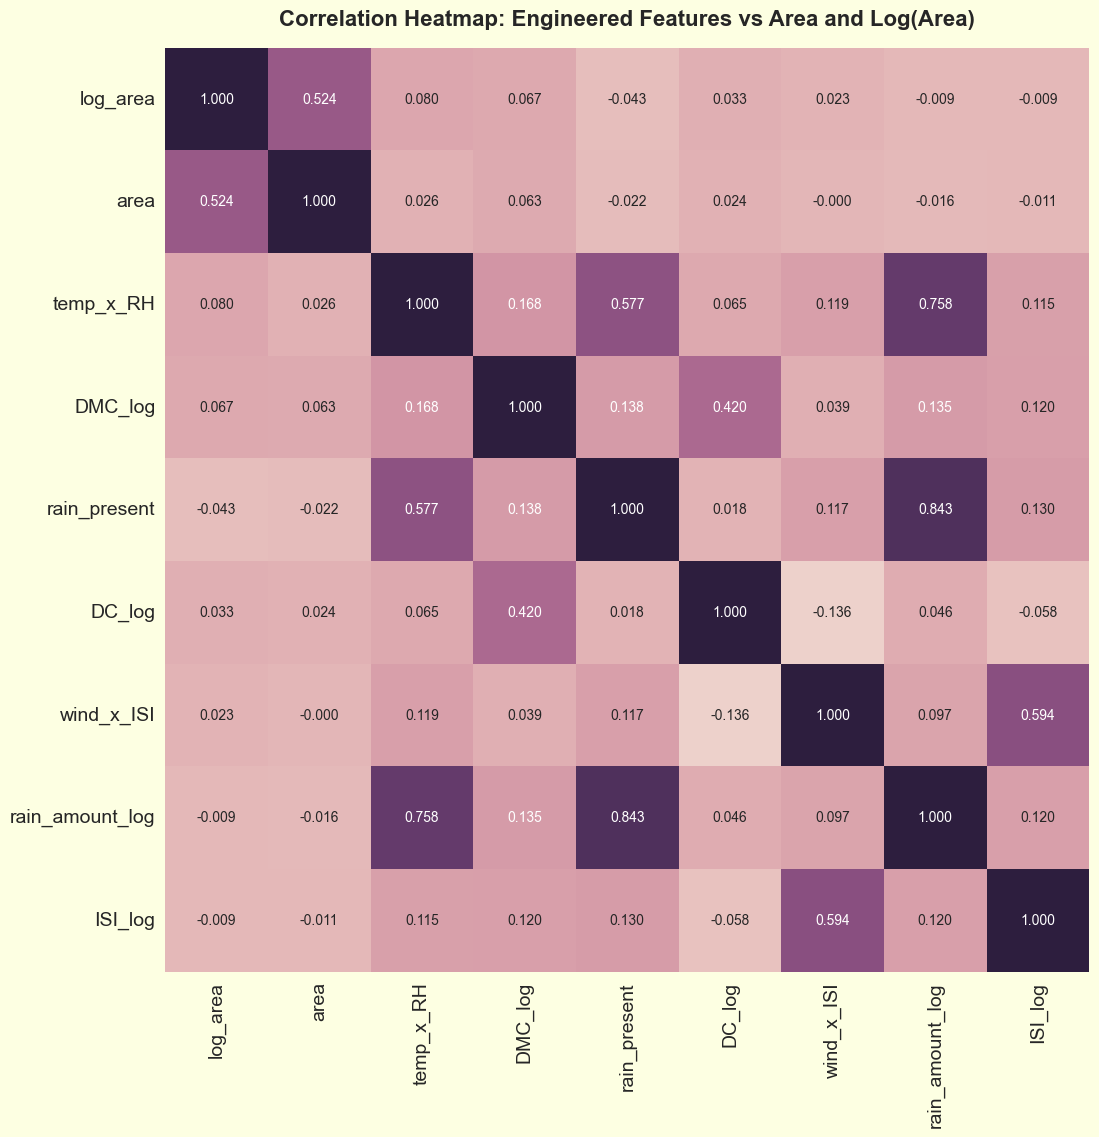

In [16]:
# Select engineered features + targets
engineered_cols = [
    "rain_present", "rain_amount_log",
    "DMC_log", "DC_log", "ISI_log",
    "wind_x_ISI", "temp_x_RH",
    "area", "log_area"
]

corr_df = fires_df[engineered_cols].corr()

# Sort rows/cols by correlation with log_area 
sorted_cols = corr_df["log_area"].abs().sort_values(ascending=False).index
corr_sorted = corr_df.loc[sorted_cols, sorted_cols]

# Plot the correlation heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(
    corr_sorted,
    annot=True, fmt=".3f", cmap=sns.cubehelix_palette(as_cmap=True),
    cbar=False, square=True, linewidths=0
)
plt.title("Correlation Heatmap: Engineered Features vs Area and Log(Area)", pad=16)
plt.show()

### Correlation Analysis of Engineered Features  

---

To evaluate the usefulness of the newly engineered features, I computed a correlation heatmap including only:  

- **Engineered predictors**: `rain_present`, `rain_amount_log`, `DMC_log`, `DC_log`, `ISI_log`, `wind_x_ISI`, `temp_x_RH`  
- **Targets**: `area`, `log_area`  

The features were sorted by their absolute correlation with `log_area` to highlight the strongest relationships with the transformed target.  

---

#### Key Observations  

- **Log vs. Raw Target**  
  - As expected, `log_area` and `area` remain strongly correlated (**0.524**), confirming that the log-transformation preserves information while stabilizing skewness.  

- **Best Predictors of `log_area`**  
  - **`temp_x_RH` (0.080)**: The interaction between temperature and humidity shows the strongest direct link with `log_area`, suggesting that dryness conditions may modestly influence burned area size.  
  - **`DMC_log` (0.067)**: The Duff Moisture Code (log-transformed) also shows some positive correlation, meaning deeper fuel moisture plays a role in fire extent.  
  - **`rain_present` (-0.043)**: Weak negative correlation, but in the expected direction (fires spread less when rain is present).  

- **Weaker Predictors**  
  - `DC_log` (0.033), `wind_x_ISI` (0.023), and `rain_amount_log` (-0.009) all have very low correlations with `log_area`.  
  - `ISI_log` is essentially uncorrelated (-0.009), which may reflect that extreme ISI values are rare in this dataset.  

- **Feature Interdependencies**  
  - Strong correlations exist among some engineered features themselves:  
    - `rain_present` ↔ `rain_amount_log` (**0.843**), as expected since one is the binary presence and the other is the magnitude.  
    - `rain_amount_log` ↔ `temp_x_RH` (**0.758**): wetter conditions tend to coincide with higher humidity × temperature effects.  
    - `wind_x_ISI` ↔ `ISI_log` (**0.594**): consistent since ISI already incorporates wind.  

---

#### Takeaway  

- No single engineered feature has a strong direct linear correlation with the target (`log_area`), which aligns with the known difficulty of this dataset.  
- However, some signals emerge: **dryness indicators (`temp_x_RH`, `DMC_log`) and rain effects** are modestly informative.  
- The weak linear correlations reinforce the need to test **nonlinear models** (e.g., Random Forests, Gradient Boosting, SVR) that can capture complex interactions and thresholds that correlation alone cannot reveal.  


In [17]:
# One-hot encode fire_season 
fires_df = pd.get_dummies(fires_df, columns=["fire_season"], drop_first=True)

# fire_season categories become:
# fire_season_low, fire_season_med, fire_season_high
# With drop_first=True → only fire_season_low and fire_season_med remain

# Define feature groups
categorical_cols = ["is_weekend", "fire_season_low", "fire_season_med"]

numeric_cols = [
    "X", "Y", "FFMC", "DMC", "DC", "ISI", "temp", "RH", "wind", "rain",
    # engineered features
    "rain_present", "rain_amount_log",
    "DMC_log", "DC_log", "ISI_log",
    "wind_x_ISI", "temp_x_RH"
]

target = "log_area"   # primary modeling target
target_raw = "area"   # keep for reference / inverse-transform

# Final feature set for modeling
final_features = categorical_cols + numeric_cols

### Encoding `fire_season` and Defining Final Feature Lists  

---

To finalize the dataset for modeling, I performed the following preprocessing steps:  

1. **Encoding `fire_season`**  
   - The categorical variable `fire_season` (low, med, high) was one-hot encoded.  
   - With `drop_first=True`, only two dummy variables remain:  
     - `fire_season_low`  
     - `fire_season_med`  
   - This avoids multicollinearity by using **low risk** as the baseline reference category.  

2. **Defining Feature Groups**  
   - **Categorical features**:  
     - `is_weekend` → binary indicator (0 = weekday, 1 = weekend).  
     - `fire_season_low`, `fire_season_med` → dummy variables from encoding.  
   - **Numeric features**:  
     - Original meteorological & spatial features: `X`, `Y`, `FFMC`, `DMC`, `DC`, `ISI`, `temp`, `RH`, `wind`, `rain`.  
     - Engineered features:  
       - `rain_present`, `rain_amount_log` (rain decomposition).  
       - `DMC_log`, `DC_log`, `ISI_log` (log-transformed fire indices).  
       - `wind_x_ISI`, `temp_x_RH` (interaction features).  
   - **Target variables**:  
     - `log_area` → primary target (stabilized, interpretable distribution).  
     - `area` → raw target (kept for reference and inverse-transform checks).  


In [18]:
# Define X and y
X = fires_df[final_features]
y = fires_df[target]   # use log_area as target

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=None  # regression target → no stratification
)

# --- columns to scale (continuous only) ---
continuous_cols = [
    "X","Y","FFMC","DMC","DC","ISI","temp","RH","wind","rain",
    "rain_amount_log","DMC_log","DC_log","ISI_log","wind_x_ISI","temp_x_RH"
]

# --- columns to pass through (no scaling): binaries/dummies ---
passthrough_cols = [c for c in X_train.columns if c not in continuous_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("scale", StandardScaler(), continuous_cols),
        ("keep", "passthrough", passthrough_cols),
    ],
    remainder="drop"
)

# --- Baseline: Linear Regression on log_area ---
lin_pipe = Pipeline([
    ("prep", preprocess),
    ("reg", LinearRegression())
])

# --- CV on train (log-scale RMSE) ---
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_rmse_log = -cross_val_score(
    lin_pipe, X_train, y_train, scoring="neg_root_mean_squared_error", cv=cv, n_jobs=-1
)

print(f"[Baseline Linear] CV RMSE (log): {cv_rmse_log.mean():.3f} ± {cv_rmse_log.std():.3f}")

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# --- Fit & predict ---
lin_pipe.fit(X_train, y_train)
y_pred_log_test = lin_pipe.predict(X_test)

# log-scale metrics
rmse_log = rmse(y_test, y_pred_log_test)
mae_log  = mean_absolute_error(y_test, y_pred_log_test)
r2_log   = r2_score(y_test, y_pred_log_test)

# Оriginal scale metrics (inverse transform)
y_test_raw = np.expm1(y_test)
y_pred_raw = np.expm1(y_pred_log_test)
rmse_raw = rmse(y_test_raw, y_pred_raw)
mae_raw  = mean_absolute_error(y_test_raw, y_pred_raw)
r2_raw   = r2_score(y_test_raw, y_pred_raw)

print(f"[Baseline Linear] Test RMSE (log): {rmse_log:.3f} | MAE (log): {mae_log:.3f} | R2 (log): {r2_log:.3f}")
print(f"[Baseline Linear] Test RMSE (raw): {rmse_raw:.2f} | MAE (raw): {mae_raw:.2f} | R2 (raw): {r2_raw:.3f}")

[Baseline Linear] CV RMSE (log): 1.426 ± 0.060
[Baseline Linear] Test RMSE (log): 1.543 | MAE (log): 1.259 | R2 (log): -0.084
[Baseline Linear] Test RMSE (raw): 109.93 | MAE (raw): 20.14 | R2 (raw): -0.025


### Baseline Model: Linear Regression  

---

To establish a reference point, I trained a **Linear Regression model** using the log-transformed target variable (`log_area`). The model included all preprocessed numeric, categorical, and engineered features. Continuous variables were standardized, while binary/dummy variables were passed through unchanged.  

---

#### Cross-Validation Performance (Training Set)
- **CV RMSE (log): 1.426 ± 0.060**  
  The average root mean squared error on the log scale indicates how well the model generalizes during training. The relatively low standard deviation suggests stable performance across folds, but the error is still fairly high.  

---

#### Test Set Performance
- **Log Scale**  
  - RMSE: **1.543**  
  - MAE: **1.259**  
  - R²: **-0.084**  
  The R² being negative means the model performs **worse than simply predicting the mean of the training target**. This shows the linear regression model fails to capture meaningful variance in the log-transformed target.  

- **Original Scale (back-transformed)**  
  - RMSE: **109.93**  
  - MAE: **20.14**  
  - R²: **-0.025**  
  The large RMSE (≈110 ha) highlights the difficulty of predicting burned area in absolute terms, especially given the heavy skew and large outliers in the dataset. The small negative R² again confirms that the linear model cannot explain the variance better than a constant mean predictor.  

---

#### Interpretation
- The **linear regression baseline performs poorly**, confirming what has been observed using this dataset:  
  - The predictors (`FFMC`, `DMC`, `DC`, weather, etc.) have **low direct correlation** with the target.  
  - The distribution of `area` is highly skewed, making linear methods struggle even after log transformation.  
- This baseline is still important because it provides a **benchmark**. Any future model (regularized linear models, polynomial/spline expansions, decision trees, random forests, gradient boosting, etc.) must improve upon these metrics to be considered useful.  


In [20]:
# Get correlations of all features vs. area and log_area
corr_targets = fires_df.corr()[["area", "log_area"]].sort_values(
    by="log_area", key=lambda x: x.abs(), ascending=False
)

# Display nicely
pd.set_option("display.float_format", "{:.3f}".format)
display(corr_targets)

,area,log_area
log_area,0.524,1.000
area,1.000,0.524
temp,0.106,0.096
temp_x_RH,0.026,0.080
DMC_log,0.063,0.067
X,0.063,0.062
DMC,0.056,0.059
FFMC,0.040,0.044
wind,-0.026,0.043
rain_present,-0.022,-0.043
